In [527]:
import numpy as np

import cv2
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit

from numpy.polynomial.polynomial import Polynomial
import random
import os
from skimage.draw import line
from scipy.ndimage import gaussian_filter1d
import skimage.morphology as morphology


import torch
from torch.distributions.gamma import Gamma

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from Solver import *
# from src.ImageClass import *
# from all import *
# from transform import *
# from draw import *

cpu


In [528]:
def generate_square_image(mask_w, mask_h, radius, border_width):
    square_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image
    center = (mask_w//2, mask_h//2)

    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, 20) 
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, -1)
    # added
    cont, _ = cv2.findContours(square_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    square_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image
    cv2.drawContours(square_image, cont, 0, 128, border_width*2)
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, 20) 
    square_image = cv2.rectangle(square_image, (center[0] - (radius-10), center[1]-(radius-10)), 
                (center[0] + (radius-10), center[1]+ (radius-10)), 255, -1)

    plt.imshow(square_image)
    return square_image


def generate_circle_image(mask_w, mask_h, radius, border_width):
    circle_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image

    center = (mask_w//2, mask_h//2)

    if border_width==1:
        cv2.circle(circle_image, center, radius, 255, 2)
        cv2.circle(circle_image, center, radius, 255, -1)
        cont, _ = cv2.findContours(circle_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        circle_image = 255*np.zeros((mask_w, mask_h), dtype=np.uint8) # blank image
        cv2.drawContours(circle_image, cont, 0, 128, border_width*2)
        cv2.circle(circle_image, center, radius, 255, 2)
        cv2.circle(circle_image, center, radius, 255, -1)
    else:
        cv2.circle(circle_image, center, radius+border_width, 128, 2)
        cv2.circle(circle_image, center, radius+border_width, 128, -1)
        cv2.circle(circle_image, center, radius, 255, 2)
        cv2.circle(circle_image, center, radius, 255, -1)

    plt.imshow(circle_image)
    

    return circle_image

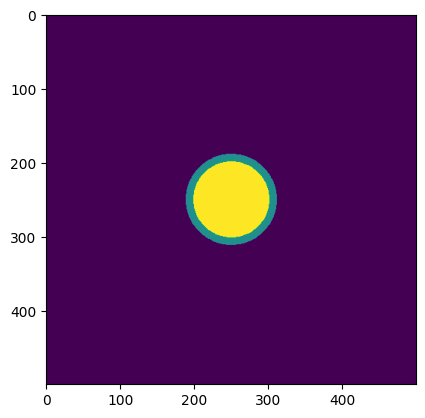

In [529]:
# square_image = generate_square_image(500,500, 50, 10)

square_image = generate_circle_image(500,500, 50, 10)

# square_image = cv2.imread('./test_line.png', 0).astype(np.float32)


In [530]:
# plt.imshow(square_image)

In [531]:
resist_thickness = 700
silicon_thickness = 100
pixel_size = 12
transform_algo = 'bezier'
algo = 'algo1'
k_value = 0.125
E_value = 10
signal_formula = 'formula_e'


flag_render_circle = 'horizontally'
flag_render_square = 'horizontally'

dp3 = (0, 1)
dp2 = (1, 0)

In [532]:
solv = Solver(algo=algo, signal_formula = signal_formula, pixel_size=pixel_size, \
                      resist_thickness=resist_thickness, k=k_value, E=E_value, masks = [square_image],\
                        recalculate=True, dp2=dp2, dp3=dp3)

Processing time: 0.8687665462493896 [sec]


True

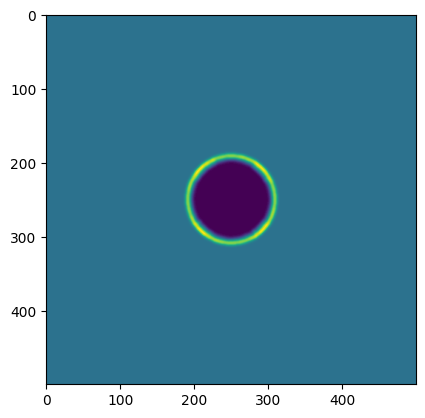

In [533]:
plt.imshow(solv.mask_objects[0].signal)

cv2.imwrite('./signal_square_original.png', solv.mask_objects[0].signal.astype(np.uint8))

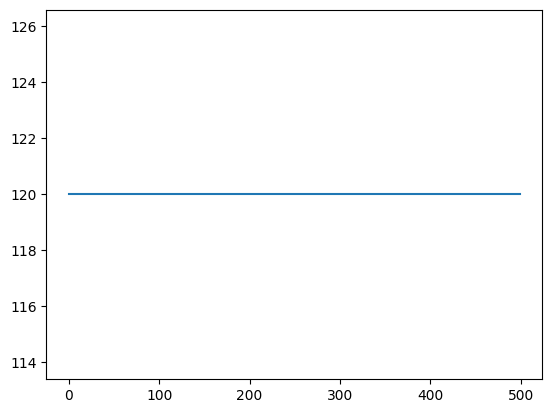

In [534]:
plt.plot(solv.mask_objects[0].signal[40,:])

### Считаем длины полосок белого, чтобы определить, широкая фигура или нет

In [535]:
def hole_width(mask):
    # можно делать более оптмизированно
    # для одного объекта брать индекс начала белой области 
    # и затем всей белой области в этой полоске присваивать длину белой области
    row_width = np.zeros_like(mask, dtype=np.uint8)
    for row in range(mask.shape[0]):
        white_pixels = np.argwhere(mask[row,:] == 255)
        for pixel in white_pixels:
            if mask[row,pixel]==255 and mask[row,pixel-1] == 128:
                start = pixel
            elif mask[row,pixel]==255 and mask[row,pixel+1] == 128:
                end = pixel
                row_width[row, start[0]:end[0]+1] = len(row_width[row, start[0]:end[0]])

    column_width = np.zeros_like(mask, dtype=np.uint8)
    for col in range(mask.shape[1]):
        white_pixels = np.argwhere(mask[:,col] == 255)
        for pixel in white_pixels:
            if mask[pixel, col] == 255 and mask[pixel-1, col] == 128:
                start = pixel
            elif mask[pixel, col] == 255 and mask[pixel+1, col] == 128:
                end = pixel
                column_width[start[0]:end[0]+1, col] = len(column_width[start[0]:end[0], col])

    return row_width, column_width

In [536]:
np.argwhere(square_image[250,:] == 255)[0]

array([199])

In [537]:
def hole_width(mask):
    # можно делать более оптмизированно
    # для одного объекта брать индекс начала белой области 
    # и затем всей белой области в этой полоске присваивать длину белой области
    row_width = np.zeros_like(mask, dtype=np.float32)
    row_start = np.argwhere(mask == 255)[0][0]
    rows_count = len(np.unique(np.argwhere(mask == 255)[:, 0]))-1
    row_end = np.unique(np.argwhere(mask == 255)[:, 0])[rows_count]
    # for row in range(mask.shape[0]-1):
    for row in range(row_start, row_end):
        # if 255 in np.unique(mask[row,:]):
        # start = np.argwhere(mask[row,:] == 255)[0][0]
        # length = len(np.argwhere(mask[row,:] == 255))-1
        # row_width[row,start:start+length+1] = int(length)
        white_pixels = np.argwhere(mask[row,:] == 255)
        for pixel in white_pixels:
            if mask[row,pixel]==255 and mask[row,pixel-1] == 128:
                start = pixel
            elif mask[row,pixel]==255 and mask[row,pixel+1] == 128:
                end = pixel
                row_width[row, start[0]:end[0]+1] = len(row_width[row, start[0]:end[0]])
    
    
    # for col in range(mask.shape[1]-1):

    # cont, _ = cv2.findContours(cv2.inRange(mask, 255, 255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # temp = np.zeros_like(mask)
    # cv2.drawContours(temp, cont, -1, 255, 0)
    # plt.imshow(temp)

    

    column_width = np.zeros_like(mask, dtype=np.float32)
    col_count = len(np.unique(np.argwhere(mask == 255)[:, 1]))-1
    col_end = np.unique(np.argwhere(mask== 255)[:, 1])[col_count]
    col_start = np.unique(np.argwhere(mask == 255)[:, 1])[0]

    # print(white)
    # print(np.argwhere(mask==255))
    for col in range(col_start, col_end):
        white_pixels = np.argwhere(mask[:,col] == 255)
        for pixel in white_pixels:
            if mask[pixel, col] == 255 and mask[pixel-1, col] == 128:
                start = pixel
            elif mask[pixel, col] == 255 and mask[pixel+1, col] == 128:
                end = pixel
                column_width[start[0]:end[0]+1, col] = len(column_width[start[0]:end[0], col])
        # white = np.where(temp[:,col]==255)[0]
        # print(white)
        # print(mask[:,col])
        # # print(np.argwhere(mask[:,col]==255)[:,0])
        # # cont_col = 
        # break
        # if 255 in np.unique(mask[:,col]):
        #     start = np.argwhere(mask[:,col] == 255)[0][0]
        #     length = len(np.argwhere(mask[:,col] == 255))-1
            
        #     column_width[start:start+length+1, col] = int(length)

        # white_pixels = np.argwhere(mask[row,:] == 255)
        # for pixel in white_pixels:
        #     if mask[row,pixel]==255 and mask[row,pixel-1] == 128:
        #         start = pixel
        #     elif mask[row,pixel]==255 and mask[row,pixel+1] == 128:
        #         end = pixel
        #         row_width[row, start[0]:end[0]+1] = len(row_width[row, start[0]:end[0]])


    # column_width = np.zeros_like(mask, dtype=np.uint8)
    # for col in range(mask.shape[1]):
    #     white_pixels = np.argwhere(mask[:,col] == 255)
    #     for pixel in white_pixels:
    #         if mask[pixel, col] == 255 and mask[pixel-1, col] == 128:
    #             start = pixel
    #         elif mask[pixel, col] == 255 and mask[pixel+1, col] == 128:
    #             end = pixel
    #             column_width[start[0]:end[0]+1, col] = len(column_width[start[0]:end[0], col])

    return row_width, column_width

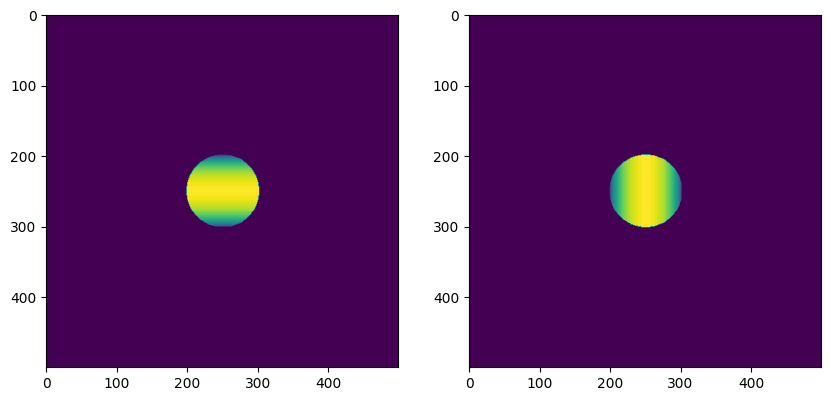

In [538]:
row_width_square, column_width_square = hole_width(square_image)

fig, ax = plt.subplots(1,2, figsize=(10,15))

ax[0].imshow(row_width_square)
ax[1].imshow(column_width_square)


[  0. 255.]
[  0.  12.  23.  30.  35.  41.  45.  49.  53.  55.  58.  61.  64.  66.
  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.  90.  92.  94.
  96.  98. 100. 102.]


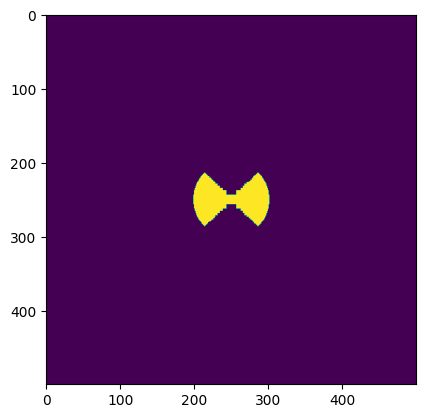

In [592]:
hole_mask = cv2.inRange(square_image, 255, 255).astype(np.float32)
print(np.unique(hole_mask))
print(np.unique(row_width_square))

# hole_mask[hole_mask==255]=1
object_width_horizontal = np.zeros_like(square_image, dtype=np.float32)
object_width_vertical = np.zeros_like(square_image, dtype=np.float32)

object_width_horizontal = cv2.bitwise_and(row_width_square, hole_mask, object_width_horizontal).astype(np.float32)
# hole = np.where(hole_mask==255)
# object_width_horizontal = row_width_square.copy()

# print(np.unique(object_width_horizontal))
object_width_horizontal[hole_mask==255] = row_width_square[hole_mask==255]
object_width_vertical[hole_mask==255] = column_width_square[hole_mask==255]


# plt.imshow(object_width_horizontal)
# object_width_vertical = cv2.bitwise_and(hole_mask, column_width_square.astype(np.float32)).astype(np.float32)

# print(np.unique(object_width_horizontal))
# wider_part = np.clip(object_width_horizontal >= object_width_vertical,0,1)
# wider_part = np.clip(cv2.bitwise_or(np.clip(object_width_horizontal > object_width_vertical,0,1), np.clip(object_width_horizontal == object_width_vertical, 0, 1)), 0, 1)
wider_part = np.clip(object_width_horizontal >= object_width_vertical,0,1) *255
# wider_part = np.clip(row_width_square >= column_width_square,0,1) *255


# wider_part[wider_part==1]=255
wider_part = np.clip(hole_mask == wider_part,0,1)*255
# wider_part[wider_part==1]=255
# print(np.unique(wider_part))

plt.imshow(wider_part)



In [581]:
object_width_horizontal.max()

61.0

In [586]:
cv2.bitwise_and(102.,255.)

array([[51.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [593]:
# def bezier_parabola(self, line, t, prev, color_back, color_hole, dp2, dp3, percent):
# def bezier_parabola(line, t, color_hole, dp2, dp3, percent):
def bezier_parabola(line, t, color_hole, percent):

    point1 = (0, color_hole)
    new_color_hole = color_hole * (1 + percent/100)
    # new_color_hole = color_hole + (1 + percent/100)

    point4 = (len(line), new_color_hole)

    point3 = (len(line)//2, new_color_hole)
    point2 = (len(line)//2, color_hole)

    # point2 = (dp3[0]*len(line), dp3[1]*(new_color_hole - color_hole) + color_hole) # default: (len(line), color_back)
    # point3 = (dp3[0]*len(line), dp3[1]*(np.abs(color_hole - color_back)) - color_back)
    # point3 = (dp2[0]*len(line), dp2[1]*(new_color_hole - color_hole) + color_hole)

    x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
    vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3

    return x, vals

    



        # if prev == 0.0:
        #     point1 = (0, color_back)
        #     point4 = (len(line), color_hole)
        #     point2 = (dp3[0]*len(line), dp3[1]*(color_back - color_hole) + color_hole) # default: (len(line), color_back)
        #     # point3 = (dp3[0]*len(line), dp3[1]*(np.abs(color_hole - color_back)) - color_back)
        #     point3 = (dp2[0]*len(line), dp2[1]*(color_back - color_hole) + color_hole) #default: (0, color_hole)
        #     # point2 = (dp2[0]*len(line), dp2[1]*(np.abs(color_hole - color_back)) - color_back)

        # if prev == 255.0:
        #     point1 = (0, color_hole)
        #     point4 = (len(line), color_back)
        #     point3 = (dp3[0]*len(line), dp3[1]*(color_back - color_hole) + color_hole) # dafault: (0, color_back)
        #     # point3 = (dp3[0]*len(line), dp3[1]*(color_hole - color_back) + color_back)
        #     point2 = (dp2[0]*len(line), dp2[1]*(color_back - color_hole) + color_hole) # default: (len(line), color_hole)
        #     # point2 = (dp2[0]*len(line), dp2[1]*(color_hole - color_back) + color_back)
        # x = point1[0]*(1-t)**3 + point2[0]*3*t*(1-t)**2 + point3[0]*3*t**2*(1-t) + point4[0]*t**3
        # vals = point1[1]*(1-t)**3 + point2[1]*3*t*(1-t)**2 + point3[1]*3*t**2*(1-t) + point4[1]*t**3
        # return x, vals

In [563]:
# dist_ = len(object_width_horizontal[250,first_index:last_index])
# new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

# x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), 85.0, 100)
# # x, new_angles = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), 0.0, 30)

# reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
# new_angles = np.arctan(np.abs(np.gradient(new_colors)))
# reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

# averages_angls = np.max(reshaped_new_angls, axis=1)
# max_indices = np.argmax(reshaped_new_angls, axis=1)
# averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

In [516]:
# solv.mask_objects[0].angles_map[250,first_index:last_index] = averages_angls
# cent = (last_index - first_index)//2
# solv.mask_objects[0].color_map[250,first_index:first_index+cent] = averages_colors[:len(averages_colors)//2]
# solv.mask_objects[0].color_map[250,first_index+cent:last_index] = averages_colors[len(averages_colors)//2-1::-1]


# solv.mask_objects[0].angles_map[first_index:first_index+object_width_horizontal[250,:].max()//2,250] = averages_angls
# solv.mask_objects[0].color_map[first_index:first_index+object_width_horizontal[250,:].max()//2, 250] = averages_colors


In [517]:
# new_signal = solv.GetSignal(solv.mask_objects[0])

# plt.imshow(new_signal)

# cv2.imwrite('./signal_square_flashedhole.png', new_signal.astype(np.uint8))

In [564]:
percent = 100
flash_hole_horizontal = 'whole'    #   {'top’, 'center', 'bottom', 'whole'}
flash_hole_vertical = 'center'       #   {'left', 'center', 'right', 'whole'}
flash = 'vertical'                  #   {'vertical', 'horizontal'}

color_hole = 85.0

- починить то, что есть пиксели, где переход от засвета к границе четкий
надо сделать так, чтобы он был плавный, то есть может присваивать пискели засвета нескольких рядам из границы
- подумать, что делать с ситуацией когда вся поверхность должна быть засвечена одинаково
потому что брать среднее - получается хуево

True

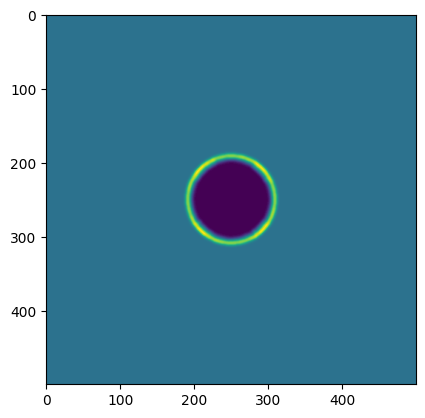

In [594]:
if np.unique(object_width_horizontal!=0).min()>=200 or np.unique(object_width_vertical!=0).min()>=200:

    if flash == 'vertical':
        if flash_hole_horizontal == 'whole':
            row_start = np.argwhere(square_image == 255)[0][0]
            rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
            row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count]

        elif flash_hole_horizontal == 'top':
            row_start = np.argwhere(square_image == 255)[0][0]
            rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
            row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count//3]
        elif flash_hole_horizontal == 'bottom':
            row_end = np.argwhere(square_image == 255)[-1][0]
            rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
            row_start = np.unique(np.argwhere(square_image == 255)[:, 0])[2*rows_count//3]
        elif flash_hole_horizontal == 'center':
            rows_count = len(np.unique(np.argwhere(square_image == 255)[:, 0]))-1
            row_start = np.unique(np.argwhere(square_image == 255)[:, 0])[rows_count//3]
            row_end = np.unique(np.argwhere(square_image == 255)[:, 0])[2*rows_count//3]
            
        for row in range(row_start, row_end):

            first_index = np.argwhere(object_width_horizontal[row,:] != 0)[0][0]
            last_index = np.argwhere(object_width_horizontal[row,:] != 0)[-1][0]
            # print(object_width_horizontal[row,:])
            # print(row, first_index, last_index)
            # break

            dist_ = len(object_width_horizontal[row,first_index:last_index])
            new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

            x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_hole, percent)

            reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
            new_angles = np.arctan(np.abs(np.gradient(new_colors)))
            reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

            averages_angls = np.max(reshaped_new_angls, axis=1)
            max_indices = np.argmax(reshaped_new_angls, axis=1)
            averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

            solv.mask_objects[0].angles_map[row,first_index:last_index] = averages_angls

            if flash_hole_vertical == 'right':
                solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors

                if solv.mask_objects[0].color_map[row,last_index:].min() < solv.mask_objects[0].color_map[row,last_index-1]:
                    mensh = np.argwhere(solv.mask_objects[0].color_map[row,last_index:] < solv.mask_objects[0].color_map[row,last_index-1])
                    solv.mask_objects[0].color_map[row,last_index:][mensh] = solv.mask_objects[0].color_map[row,last_index-1]
            
            elif flash_hole_vertical == 'left':
                solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors[::-1]
                border_indexes = np.argwhere(solv.mask_objects[0].mask[row,:]==128)

                # тут делаем яркость левой границы больше из-за засвета, дальше засвет не ведем
                # уточнить, надо ли
                if solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1].min() < solv.mask_objects[0].color_map[row,first_index]:
                    mensh = np.argwhere(solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1] < solv.mask_objects[0].color_map[row,first_index])
                    solv.mask_objects[0].color_map[row,first_index-1:border_indexes[0][0]:-1][mensh] = solv.mask_objects[0].color_map[row,first_index]
            elif flash_hole_vertical == 'center':
                cent = (last_index - first_index)//2
                solv.mask_objects[0].color_map[row, first_index:first_index+cent] = averages_colors[:len(averages_colors)//2]
                solv.mask_objects[0].color_map[row, first_index+cent-1:last_index] = averages_colors[len(averages_colors)//2::-1]

    elif flash == 'horizontal':
        if flash_hole_vertical == 'whole':
            col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
            col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count]
            col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[0]

        elif flash_hole_vertical == 'left':
            col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
            col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count//3]
            col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[0]
        elif flash_hole_vertical == 'right':
            col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
            col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[2*col_count//3]
            col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count]

        elif flash_hole_vertical == 'center':
            col_count = len(np.unique(np.argwhere(square_image == 255)[:, 1]))-1
            col_start = np.unique(np.argwhere(square_image == 255)[:, 1])[col_count//3]
            col_end = np.unique(np.argwhere(square_image == 255)[:, 1])[2*col_count//3]

        for col in range(col_start, col_end):

            first_index = np.argwhere(object_width_horizontal[:,col] != 0)[0][0]
            last_index = np.argwhere(object_width_horizontal[:,col] != 0)[-1][0]

            dist_ = len(object_width_horizontal[first_index:last_index, col])
            new_line = np.zeros(dist_*pixel_size, dtype=np.float32)
            x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_hole, percent)
            reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
            new_angles = np.arctan(np.abs(np.gradient(new_colors)))
            reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

            averages_angls = np.max(reshaped_new_angls, axis=1)
            max_indices = np.argmax(reshaped_new_angls, axis=1)
            averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

            solv.mask_objects[0].angles_map[first_index:last_index, col] = averages_angls
            if flash_hole_horizontal == 'center':
                cent = (last_index - first_index)//2
                solv.mask_objects[0].color_map[first_index:first_index+cent, col] = averages_colors[:len(averages_colors)//2]
                solv.mask_objects[0].color_map[first_index+cent-1:last_index, col] = averages_colors[len(averages_colors)//2::-1]
            elif flash_hole_horizontal == 'bottom':
                solv.mask_objects[0].color_map[first_index:last_index, col] =  averages_colors
                if solv.mask_objects[0].color_map[last_index:, col].min() < solv.mask_objects[0].color_map[last_index-1, col]:
                    mensh = np.argwhere(solv.mask_objects[0].color_map[last_index:last_index+1, col] < solv.mask_objects[0].color_map[last_index-1, col])
                    solv.mask_objects[0].color_map[last_index:last_index+1, col][mensh] = solv.mask_objects[0].color_map[last_index-1, col]

            elif flash_hole_horizontal == 'top':
                solv.mask_objects[0].color_map[first_index:last_index, col] =  averages_colors[::-1]
                if solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col].min() < solv.mask_objects[0].color_map[first_index, col]:
                    mensh = np.argwhere(solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col] < solv.mask_objects[0].color_map[first_index, col])
                    solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col][mensh] = solv.mask_objects[0].color_map[first_index, col]

            if flash_hole_vertical == 'left': solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_start-1] = solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_start]
            if flash_hole_vertical == 'right': solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_end+1] = solv.mask_objects[0].color_map[first_index-1:first_index-2:-1, col_end]




new_signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(new_signal)

cv2.imwrite('./signal_square_flashedhole.png', new_signal.astype(np.uint8))
        
        

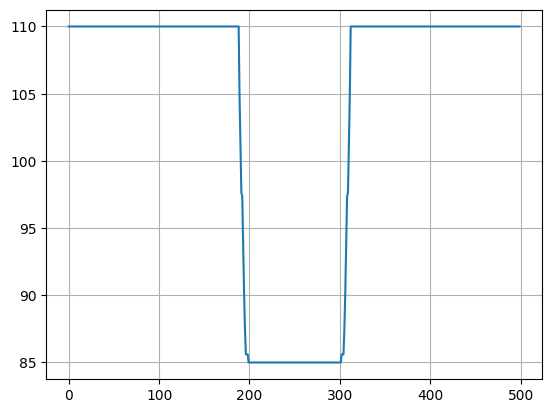

In [595]:
# plt.plot(solv.mask_objects[0].angles_map[250,:])
plt.plot(solv.mask_objects[0].color_map[250,:])
plt.grid()


Text(0.5, 1.0, 'Срез посередине фигуры с засветом справа')

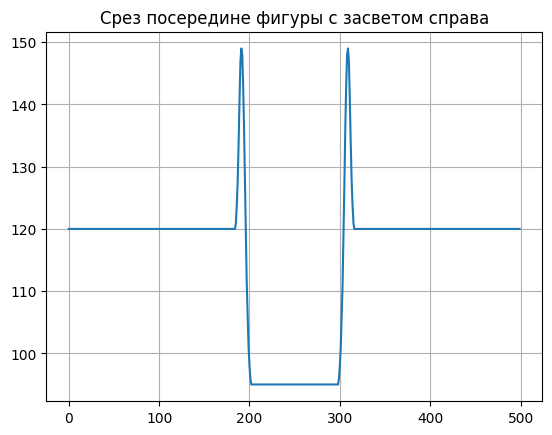

In [596]:
plt.plot(solv.mask_objects[0].signal[250,:])
plt.grid()
plt.title('Срез посередине фигуры с засветом справа')

In [597]:
# a = random.randint(40, 50)
# b = random.randint(5, 10)
a = 50
b = 6
m = Gamma(torch.tensor([a], dtype=torch.float32), torch.tensor([b], dtype=torch.float32))
sample = m.sample()
sample.item()

clean = torch.Tensor(new_signal)
noisy = clean +  m.sample()* torch.randn(clean.shape)
res_noisy = clean + m.sample()* torch.randn(clean.shape)

cv2.imwrite('./raw_square_flashedhole.png', np.clip(res_noisy.numpy(),0,255).astype(np.uint8))


True

Text(0.5, 1.0, 'Срез посередине шумной фигуры с засветом слева')

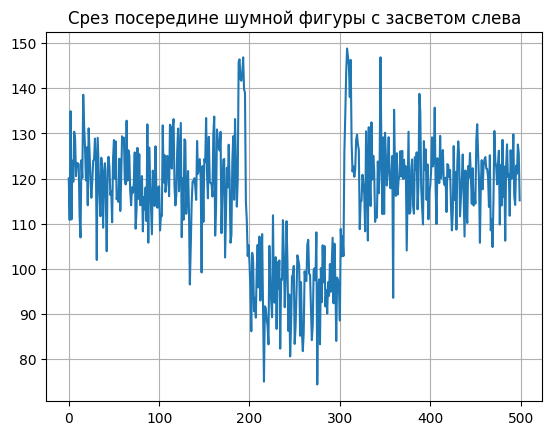

In [598]:
plt.plot(res_noisy[250,:])
plt.grid()
plt.title('Срез посередине шумной фигуры с засветом слева')


In [599]:
flash_side = True # {'True', 'False'}
cat_flash_side = 'left' # {'left', 'right', 'both'}
percent_flash_side = 50
color_back = 110.0

### REMIND: Добавить ситуацию both

True

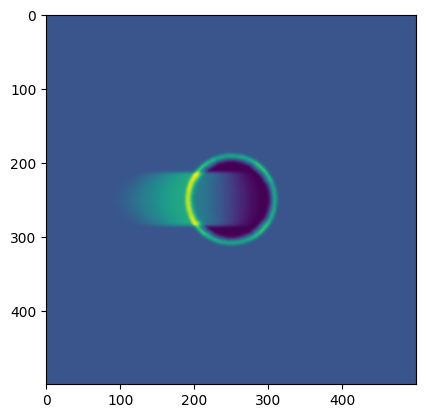

In [600]:
if 255 in wider_part:
    rows_count = len(np.unique(np.argwhere(wider_part == 255)[:, 0]))-1
    row_end = np.unique(np.argwhere(wider_part == 255)[:, 0])[rows_count]
    row_start = np.unique(np.argwhere(wider_part == 255)[:, 0])[0]

    for row in range(row_start, row_end):
        if 255 in np.unique(wider_part[row, :]):
            if cat_flash_side == 'right':
                print(wider_part[row, :])
                first_index = np.argwhere(wider_part[row,:] != 0)[0][0]
                last_index = np.argwhere(solv.mask_objects[0].mask[row,:]==128)[-1][0]
                dist_ = len(object_width_horizontal[row,first_index:last_index])
            elif cat_flash_side == 'left':
                last_index = np.argwhere(wider_part[row,:] != 0)[-1][0]
                first_index = np.argwhere(solv.mask_objects[0].mask[row,:]==128)[0][0]

                dist_ = len(object_width_horizontal[row,last_index:first_index:-1])
            
            new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

            x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_hole, percent_flash_side)

            reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
            new_angles = np.arctan(np.abs(np.gradient(new_colors)))
            reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

            averages_angls = np.max(reshaped_new_angls, axis=1)
            max_indices = np.argmax(reshaped_new_angls, axis=1)
            averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]
            
            if cat_flash_side == 'right':
                solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors

                new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

                x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_back, percent_flash_side-20)

                reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
                new_angles = np.arctan(np.abs(np.gradient(new_colors)))
                reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

                averages_angls = np.max(reshaped_new_angls, axis=1)
                max_indices = np.argmax(reshaped_new_angls, axis=1)
                averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

                length = (last_index - first_index)
                if last_index+length > solv.mask_objects[0].mask.shape[1]: lim=solv.mask_objects[0].mask.shape[1]-1
                else:lim=last_index+length
                print(last_index+length , lim, last_index, length)
                solv.mask_objects[0].color_map[row,last_index:lim] =  averages_colors[-1:-(np.abs(lim-last_index+1)):-1]

            elif cat_flash_side == 'left':
                solv.mask_objects[0].color_map[row,first_index:last_index] =  averages_colors[::-1]

                new_line = np.zeros(dist_*pixel_size, dtype=np.float32)

                x, new_colors = bezier_parabola(new_line, np.linspace(0, 1, len(new_line)), color_back, percent_flash_side-20)

                reshaped_new_colors  = np.array(new_colors).reshape(-1, pixel_size)
                new_angles = np.arctan(np.abs(np.gradient(new_colors)))
                reshaped_new_angls  = np.array(new_angles).reshape(-1, pixel_size)

                averages_angls = np.max(reshaped_new_angls, axis=1)
                max_indices = np.argmax(reshaped_new_angls, axis=1)
                averages_colors = reshaped_new_colors[np.arange(len(reshaped_new_colors)), max_indices]

                length = (last_index - first_index)
                if first_index-length < 0: lim=0
                else:lim=first_index-length
                solv.mask_objects[0].color_map[row,first_index:lim:-1] =  averages_colors[-1:-(first_index-lim)-1:-1]










        
new_signal = solv.GetSignal(solv.mask_objects[0])

plt.imshow(new_signal)
cv2.imwrite('./signal_square_flashside.png', new_signal.astype(np.uint8))

    

In [431]:
last_index = np.argwhere(wider_part[row,:] != 0)[0][0]
        # first_index = np.argwhere(object_width_horizontal[row,:] != 0)[-1][0]
first_index = np.argwhere(solv.mask_objects[0].mask[row,:]==128)[-1][0]

dist_ = len(object_width_horizontal[row,first_index:last_index:-1])
dist_

105

In [93]:
object_width_horizontal[row,last_index:first_index:-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48., 48.,
       48., 48.], dtype=float32)

In [614]:
np.argwhere(wider_part[53,:] == 255)[1][0]

447

In [602]:
np.unique(np.argwhere(wider_part == 255))

array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 23